In [1]:
import cantata
from cantata.analysis.quantify import quantify_stimulated, quantify_unstimulated
import cantata.analysis.util as cantu
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cantata.plotting import output as cp
import pandas as pd
from timeit import timeit

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [3]:
%load_ext autoreload
%autoreload 2
%aimport -torch -np -plt -sns -pd

In [4]:
figsize = (14,5)

batch_size = 32
dt = 1e-3
device = torch.device('cuda')

In [5]:
conf = cantata.config.read('/home/felix/projects/cantata/cantata/configs/1tier.yaml')
conf.pop('_prototypes')
print(conf.to_yaml())

input:
  n_channels: 1
  populations:
    Thal:
      n: 20
      channel: 0
      targets:
        L1:Exc:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmin: 0.0
          wmax: 1.0
        L1:Inh:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmin: 0.0
          wmax: 1.0
areas:
  L1:
    populations:
      Exc:
        sign: 1
        n: 200
        p: -0.1
        noise_N: 2000
        noise_rate: 8.0
        noise_weight: 0.002
        th_ampl: 0.05
        targets:
          Exc:
            spatial: true
            density: 0.5
            delay: 0.001
            STDP_frac: 1.0
            A_p: 0.2
            A_d: 0.2
            sigma: 0.5
            wmin: 0.0
            wmax: 1.0
          Inh:
            spatial: true
            density

In [6]:
# Parameters to consider:
conf_options = (
    ('input.populations.Thal.targets.L1:Exc.STDP_frac', [0., 1.]),
    ('input.populations.Thal.targets.L1:Exc.A_p', [.05, .1, .2],
         lambda c: c.input.populations.Thal.targets['L1:Exc'].STDP_frac>0),
    ('input.populations.Thal.targets.L1:Exc.A_d', [.05, .1, .2],
         lambda c: c.input.populations.Thal.targets['L1:Exc'].STDP_frac>0),
    ('input.populations.Thal.targets.L1:Exc.wmax', [.2, .5, 1.]),
    ('input.populations.Thal.targets.L1:Exc.density', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Exc.sigma', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.wmax', [.2, .5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.density', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.sigma', [.5, 1.]),

    ('areas.L1.tau_p', [.01, .02, .04]),
    ('areas.L1.tau_d', [.01, .02, .04]),
    ('areas.L1.populations.Exc.p', [0., -.1, -.2]),
    ('areas.L1.populations.Exc.noise_weight', [.0005, .001, .002]),
    ('areas.L1.populations.Exc.th_ampl', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Exc.density', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Exc.sigma', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Exc.wmax', [.2, .5, 1.]),
    ('areas.L1.populations.Exc.targets.Exc.A_p', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Exc.A_d', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Inh.density', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Inh.sigma', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Inh.wmax', [.2, .5, 1.]),

    ('areas.L1.populations.Inh.noise_weight', [.0005, .001, .002]),
    ('areas.L1.populations.Inh.targets.Exc.density', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Exc.sigma', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Exc.wmax', [.2, .5, 1.]),
    ('areas.L1.populations.Inh.targets.Inh.density', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Inh.sigma', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Inh.wmax', [.2, .5, 1.])
)

In [7]:
def subdict_set(ancestor, paths, values):
    if type(paths) == str:
        paths = [paths]
        values = [values]
    for path,value in zip(paths,values):
        parent = ancestor
        path = path.split('.')
        for key in path[:-1]:
            parent = parent[key]
        parent[path[-1]] = value

def single_configurations(conf, options, sequence = 0):
    conf = conf.copy()
    i = 0
    for entry in options:
        key, values, *condition = entry
        for value in values:
            if i == sequence:
                ret = conf.copy()
                subdict_set(ret, key, value)
                if len(condition) == 0 or condition[0](conf):
                    yield ret, sequence, key, value
                sequence += 1
            i += 1

def combinatorial_configurations(conf, options, seq = 0):
    if len(options) == 1:
        for c,s,k,v in single_configurations(conf, options, seq):
            yield c, s, (k,), (v,)
    else:
        head, tail = options[:1], options[1:]
        tail_length = np.prod([len(entry[1]) for entry in tail])
        for hconf, hseq, hkey, hvalue in combinatorial_configurations(conf, head, seq // tail_length):
            for tconf, tseq, tkey, tvalue in combinatorial_configurations(hconf, tail, seq % tail_length):
                seq = hseq*tail_length + tseq
                yield tconf, seq, (*hkey, *tkey), (*hvalue, *tvalue)
            seq += 1

In [8]:
periods = (int(50e-3/dt), int(50e-3/dt)) # ticks
rates = (0, 50) # Hz

settle, early, late = 5, (10,15), (25,30) # seconds

assert int(1/dt) % sum(periods) == 0

In [9]:
def test_batch_size():
    res = []
    for batch_size in [8,16,32,64]:
        def fn():
            m = cantata.Conductor(conf, batch_size, dt, shared_weights = False).to(device)
            with torch.no_grad():
                r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
                m.reset()
                r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
                    m, periods, rates, dt, settle=settle, early=early, late=late)
        res.append((batch_size, timeit(fn, setup='gc.enable()', number=1)))
        yield res
print(cantu.runonce(test_batch_size, 'data/test_batch_size.pkl'))

Running test_batch_size, saving to data/test_batch_size.pkl.
[(8, 90.58161336699999), (16, 95.29347169900001), (32, 133.00133772199996), (64, 212.281705859)]


In [10]:
batch_size = 32

In [11]:
m = cantata.Conductor(conf, batch_size, dt, shared_weights = False)
widx = pd.MultiIndex.from_product([
    ['no_stim', 'stim'],
    ['early', 'late'],
    ['time_mean', 'time_std', 'wmean', 'wstd', 'sat_lo', 'sat_hi', *['q'+str(i) for i in range(11)]]
])

ridx = pd.MultiIndex.from_product([
    ['no_stim', 'stim'],
    ['early', 'late'],
    m.areas[0].p_names,
    ['mean', 'std', 'tvar_mean', 'tvar_std', *['q'+str(i) for i in range(11)]]
])

sidx = pd.MultiIndex.from_product([
    ['early', 'late'],
    m.areas[0].p_names,
    ['off', 'on'],
    ['level', 'onset', 'mean', 'std', *['q'+str(i) for i in range(11)]]
])
del m

In [12]:
def fn():
    wdata = pd.DataFrame(index=widx)
    rdata = pd.DataFrame(index=ridx)
    sdata = pd.DataFrame(index=sidx)
    
    for iconf, seq, key, value in combinatorial_configurations(conf, [
        ('areas.L1.populations.Exc.noise_weight', [0.5e-3, 1e-3, 2e-3, 4e-3, 8e-3]),
        ('areas.L1.populations.Inh.noise_weight', [0.5e-3, 1e-3, 2e-3, 4e-3, 8e-3])
    ]):
        m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
        with torch.no_grad():
            r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
            m.reset()
            r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
                m, periods, rates, dt, settle=settle, early=early, late=late)

        ru = torch.stack((r0_u, r1_u))
        wu = torch.stack((w0_u, w1_u))
        rs = torch.stack((r0_s, r1_s))
        ws = torch.stack((w0_s, w1_s))

        wseries = pd.Series(torch.stack((wu, ws)).flatten(), index=widx, name=(seq,key,value))
        rseries = pd.Series(torch.stack((ru, rs)).flatten(), index=ridx, name=(seq,key,value))
        sseries = pd.Series(torch.stack((s0, s1)).flatten(), index=sidx, name=(seq,key,value))

        wdata = pd.concat([wdata, wseries], axis=1)
        rdata = pd.concat([rdata, rseries], axis=1)
        sdata = pd.concat([sdata, sseries], axis=1)

        print(seq)
        yield wdata, rdata, sdata

noiselevel_wdata, noiselevel_rdata, noiselevel_sdata = cantu.runonce(fn, 'data/noiselevel.pkl')

Running fn, saving to data/noiselevel.pkl.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [36]:
rdataL = noiselevel_rdata.rename(columns = {c:c[2] for c in noiselevel_rdata.columns}, errors='raise')

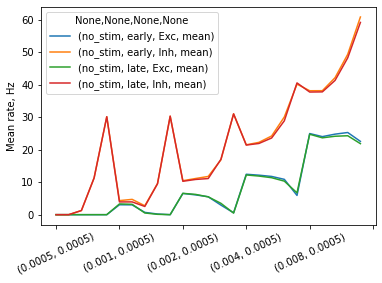

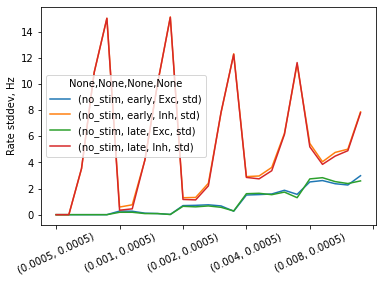

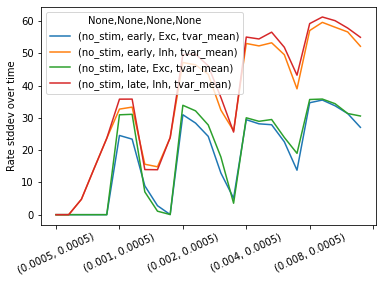

In [37]:
ix = pd.IndexSlice
rdataL.loc[ix['no_stim',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix['no_stim',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix['no_stim',:,:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

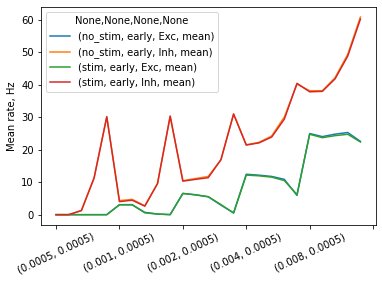

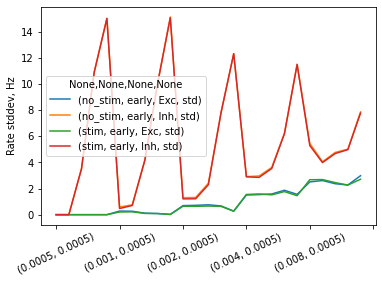

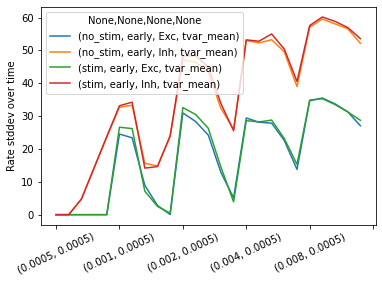

In [39]:
rdataL.loc[ix[:,'early',:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix[:,'early',:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix[:,'early',:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

In [16]:
sdataL = noiselevel_sdata.rename(columns = {c:c[2] for c in noiselevel_sdata.columns}, errors='raise')

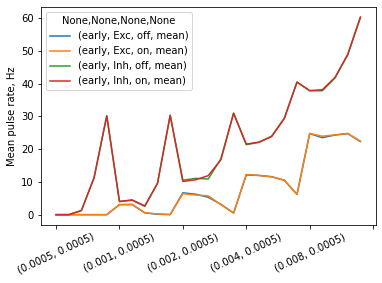

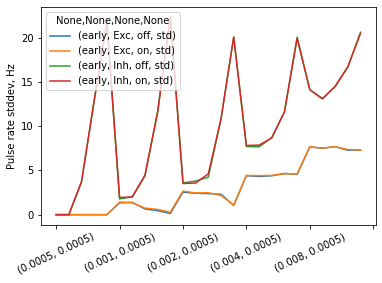

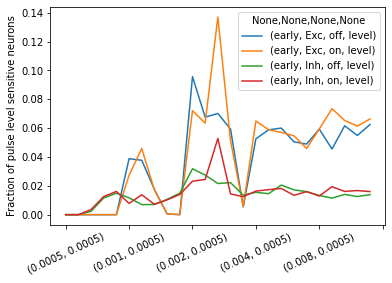

In [17]:
sdataL.loc[ix['early',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean pulse rate, Hz')
sdataL.loc[ix['early',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Pulse rate stddev, Hz')
sdataL.loc[ix['early',:,:,['level']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Fraction of pulse level sensitive neurons');

So apparently, my 20 thalamic neurons firing at 50 Hz are not enough to have a noticeable impact.

In [18]:
def fn():
    wdata = pd.DataFrame(index=widx)
    rdata = pd.DataFrame(index=ridx)
    sdata = pd.DataFrame(index=sidx)
    
    for iconf, seq, key, value in combinatorial_configurations(conf, [
        (('areas.L1.populations.Exc.noise_weight','areas.L1.populations.Inh.noise_weight'),
         ((.5e-3, .5e-3), (1e-3,1e-3), (2e-3,2e-3), (4e-3,4e-3), (8e-3,8e-3))),
        (('input.populations.Thal.targets.L1:Exc.wmin', 'input.populations.Thal.targets.L1:Inh.wmin'),
         ((0.,0.), (.25,.25), (.5,.5), (.75,.75)))
    ]):
        m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
        with torch.no_grad():
            r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
            m.reset()
            r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
                m, periods, rates, dt, settle=settle, early=early, late=late)

        ru = torch.stack((r0_u, r1_u))
        wu = torch.stack((w0_u, w1_u))
        rs = torch.stack((r0_s, r1_s))
        ws = torch.stack((w0_s, w1_s))

        wseries = pd.Series(torch.stack((wu, ws)).flatten(), index=widx, name=(seq,key,value))
        rseries = pd.Series(torch.stack((ru, rs)).flatten(), index=ridx, name=(seq,key,value))
        sseries = pd.Series(torch.stack((s0, s1)).flatten(), index=sidx, name=(seq,key,value))

        wdata = pd.concat([wdata, wseries], axis=1)
        rdata = pd.concat([rdata, rseries], axis=1)
        sdata = pd.concat([sdata, sseries], axis=1)

        print(seq)
        yield wdata, rdata, sdata, conf

noise_wmin_wdata, noise_wmin_rdata, noise_wmin_sdata, _ = cantu.runonce(fn, 'data/noise_wmin.pkl')

Running fn, saving to data/noise_wmin.pkl.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [40]:
rdataL = noise_wmin_rdata.rename(columns = {c:c[2] for c in noise_wmin_rdata.columns}, errors='raise')

In [41]:
rdataL.columns

Index([  ((0.0005, 0.0005), (0.0, 0.0)), ((0.0005, 0.0005), (0.25, 0.25)),
         ((0.0005, 0.0005), (0.5, 0.5)), ((0.0005, 0.0005), (0.75, 0.75)),
           ((0.001, 0.001), (0.0, 0.0)),   ((0.001, 0.001), (0.25, 0.25)),
           ((0.001, 0.001), (0.5, 0.5)),   ((0.001, 0.001), (0.75, 0.75)),
           ((0.002, 0.002), (0.0, 0.0)),   ((0.002, 0.002), (0.25, 0.25)),
           ((0.002, 0.002), (0.5, 0.5)),   ((0.002, 0.002), (0.75, 0.75)),
           ((0.004, 0.004), (0.0, 0.0)),   ((0.004, 0.004), (0.25, 0.25)),
           ((0.004, 0.004), (0.5, 0.5)),   ((0.004, 0.004), (0.75, 0.75)),
           ((0.008, 0.008), (0.0, 0.0)),   ((0.008, 0.008), (0.25, 0.25)),
           ((0.008, 0.008), (0.5, 0.5)),   ((0.008, 0.008), (0.75, 0.75))],
      dtype='object')

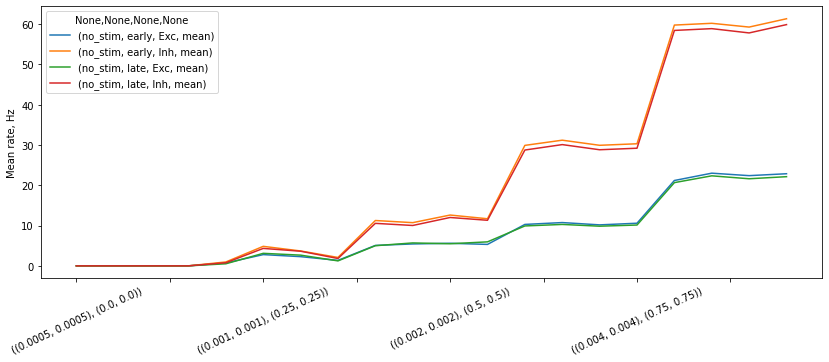

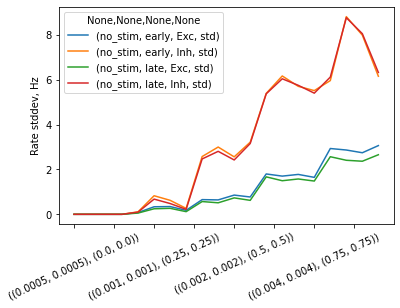

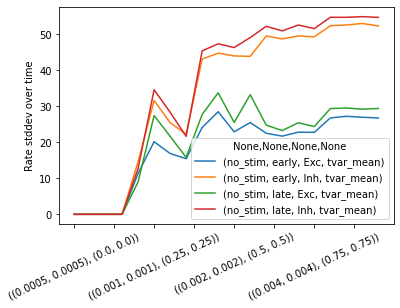

In [43]:
ix = pd.IndexSlice
rdataL.loc[ix['no_stim',:,:,['mean']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix['no_stim',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix['no_stim',:,:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

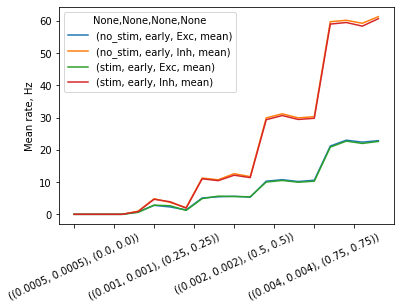

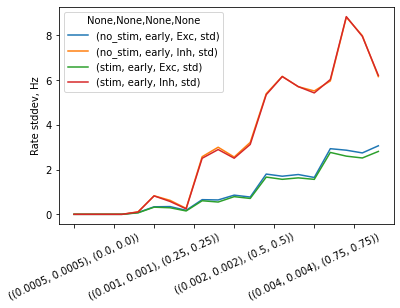

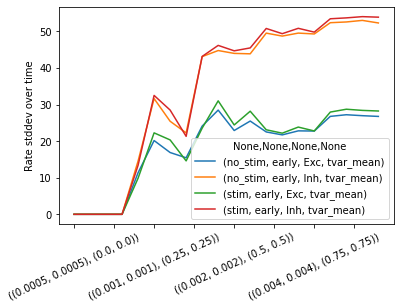

In [44]:
rdataL.loc[ix[:,'early',:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix[:,'early',:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix[:,'early',:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

In [23]:
sdataL = noise_wmin_sdata.rename(columns = {c:c[2] for c in noise_wmin_sdata.columns}, errors='raise')

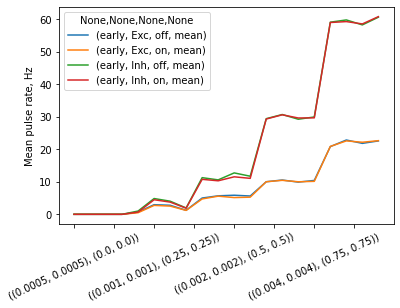

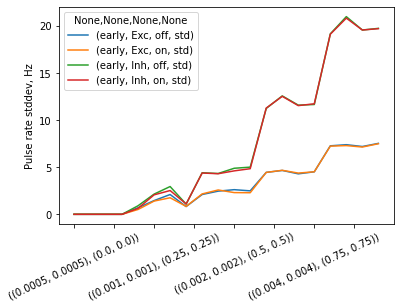

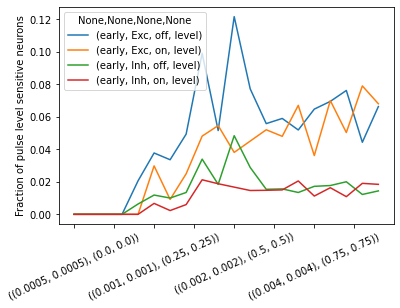

In [24]:
sdataL.loc[ix['early',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean pulse rate, Hz')
sdataL.loc[ix['early',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Pulse rate stddev, Hz')
sdataL.loc[ix['early',:,:,['level']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Fraction of pulse level sensitive neurons');

In [30]:
def fn():
    wdata = pd.DataFrame(index=widx)
    rdata = pd.DataFrame(index=ridx)
    sdata = pd.DataFrame(index=sidx)
    
    mconf = conf.copy()
    mconf.areas.L1.populations.Exc.noise_weight = 4e-3
    mconf.areas.L1.populations.Inh.noise_weight = 4e-3
    mconf.input.populations.Thal.targets['L1:Exc'].wmin = .25
    mconf.input.populations.Thal.targets['L1:Inh'].wmin = .25
    
    
    for iconf, seq, key, value in combinatorial_configurations(conf, [
        ('areas.L1.populations.Exc.targets.Exc.density', [.2, .5]),
        ('areas.L1.populations.Exc.targets.Inh.density', [.2, .5]),
        ('areas.L1.populations.Inh.targets.Exc.density', [.2, .5]),
        ('areas.L1.populations.Inh.targets.Inh.density', [.2, .5]),
        ('areas.L1.populations.Exc.targets.Exc.sigma', [.2, .5]),
        ('areas.L1.populations.Exc.targets.Inh.sigma', [.2, .5]),
        ('areas.L1.populations.Inh.targets.Exc.sigma', [.2, .5]),
        ('areas.L1.populations.Inh.targets.Inh.sigma', [.2, .5])
    ]):
        m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
        with torch.no_grad():
            r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
            m.reset()
            r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
                m, periods, rates, dt, settle=settle, early=early, late=late)

        ru = torch.stack((r0_u, r1_u))
        wu = torch.stack((w0_u, w1_u))
        rs = torch.stack((r0_s, r1_s))
        ws = torch.stack((w0_s, w1_s))

        wseries = pd.Series(torch.stack((wu, ws)).flatten(), index=widx, name=(seq,key,value))
        rseries = pd.Series(torch.stack((ru, rs)).flatten(), index=ridx, name=(seq,key,value))
        sseries = pd.Series(torch.stack((s0, s1)).flatten(), index=sidx, name=(seq,key,value))

        wdata = pd.concat([wdata, wseries], axis=1)
        rdata = pd.concat([rdata, rseries], axis=1)
        sdata = pd.concat([sdata, sseries], axis=1)

        print(seq)
        yield wdata, rdata, sdata, mconf

density_sigma_wdata, density_sigma_rdata, density_sigma_sdata, _ = cantu.runonce(fn, 'data/density_sigma.pkl')

Running fn, saving to data/density_sigma.pkl.
Successfully loaded result from data/density_sigma.pkl.
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [45]:
rdataL = density_sigma_rdata.rename(columns = {c:c[2] for c in density_sigma_rdata.columns}, errors='raise')

In [73]:
rdataL = rdataL.reindex(columns = pd.MultiIndex.from_tuples(
    rdataL.columns, names=['dee','dei','die','dii','see','sei','sie','sii']))

In [74]:
rdataL

dee                                0.2                                   \
dei                                0.2                                    
die                                0.2                                    
dii                                0.2                                    
see                                0.2                                    
sei                                0.2                                    
sie                                0.2                   0.5              
sii                                0.2        0.5        0.2        0.5   
no_stim early Exc mean        2.390594   2.132062   1.425156   1.476406   
                  std         2.422409   2.346428   2.180825   2.094187   
                  tvar_mean   4.157047   3.996682   3.060929   3.049922   
                  tvar_std    0.442587   0.538083   0.359778   0.330481   
                  q0          0.000000   0.000000   0.000000   0.000000   
..                                 ...        ...        ...        ...   
stim    late  Inh q6          1.700000   2.412500   1.050000   1.281250   
                  q7          2.446875   3.312500   1.215625   1.556250   
                  q8          2.862500   4.050000   1.462500   2.056250   
                  q9          5.224999   7.649999   2.162500  11.681250   
                  q10        18.074997  20.037498  15.612499  17.674997   

dee                                                                      \
dei                                                                       
die                                                                       
dii                                                                       
see                                                                       
sei                                0.5                                    
sie                                0.2                   0.5              
sii                                0.2        0.5        0.2        0.5   
no_stim early Exc mean        1.858062   2.205250   1.168156   1.383031   
                  std         2.404428   2.555598   1.654117   1.753338   
                  tvar_mean   3.481686   3.929184   2.776916   2.984008   
                  tvar_std    0.388163   0.428306   0.281411   0.283872   
                  q0          0.000000   0.000000   0.000000   0.000000   
..                                 ...        ...        ...        ...   
stim    late  Inh q6          7.774999   6.924999   3.993750   4.425000   
                  q7          8.921875   7.706249   5.115624   5.462500   
                  q8         10.593749   9.612499   5.849999   6.987500   
                  q9         14.549999  14.449999   8.690624  12.040625   
                  q10        21.287498  19.906248  18.481247  17.237499   

dee                                                ...        0.5             \
dei                                                ...        0.5              
die                                                ...        0.5              
dii                                                ...        0.5              
see                                0.5             ...        0.2              
sei                                0.2             ...        0.5              
sie                                0.2             ...        0.5              
sii                                0.2        0.5  ...        0.2        0.5   
no_stim early Exc mean        8.317780   7.395656  ...   1.132281   1.387719   
                  std         1.237689   1.498955  ...   1.118084   1.318008   
                  tvar_mean  27.921318  25.010941  ...   3.406369   3.974050   
                  tvar_std    4.413900   3.492280  ...   0.356259   0.357824   
                  q0          5.037500   2.350000  ...   0.050000   0.025000   
..                                 ...        ...  ...        ...        ...   
stim    late  Inh q6        

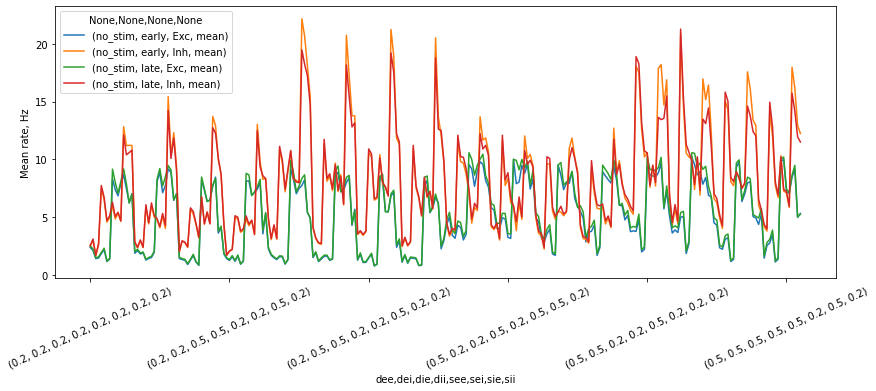

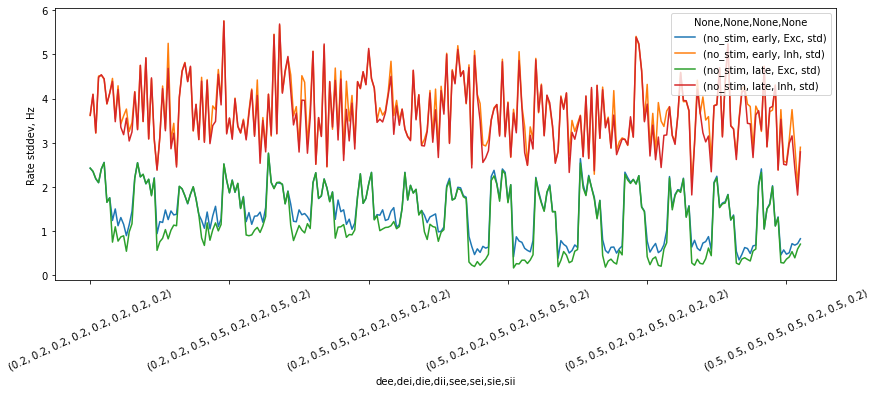

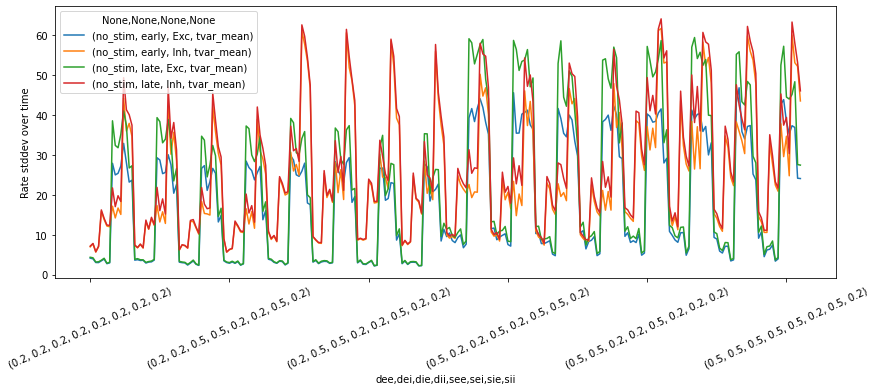

In [83]:
ix = pd.IndexSlice
rdataL.loc[ix['no_stim',:,:,['mean']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix['no_stim',:,:,['std']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix['no_stim',:,:,['tvar_mean']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

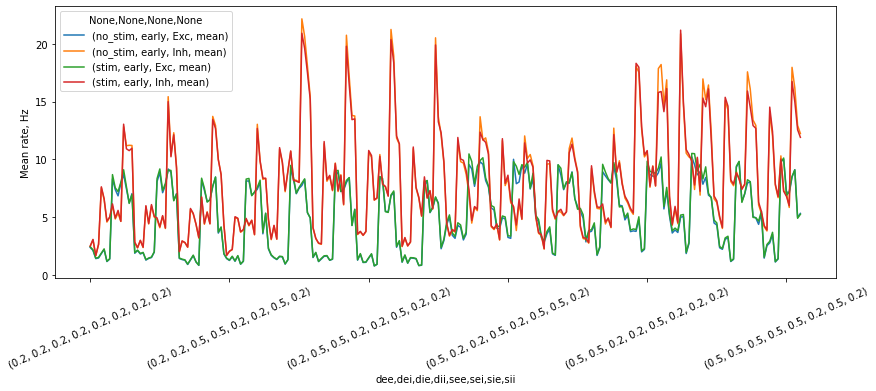

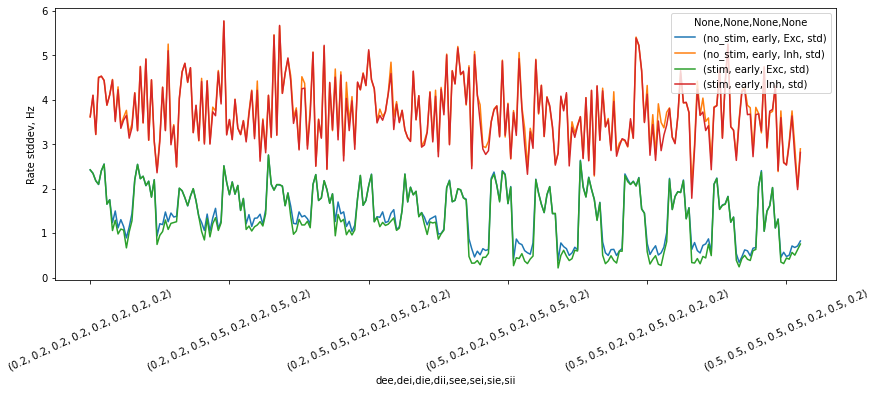

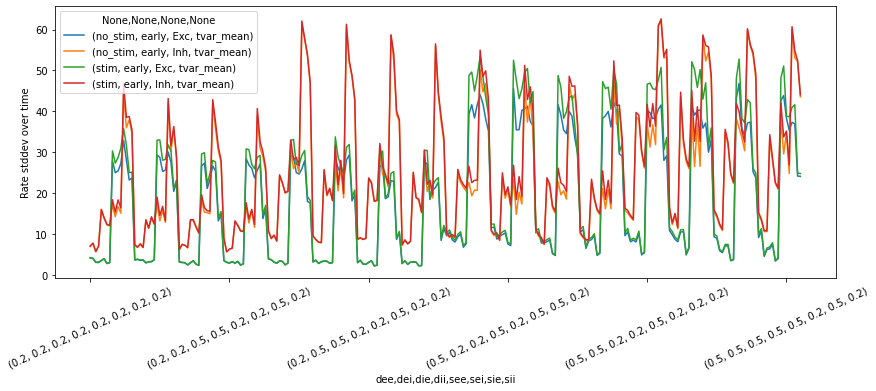

In [85]:
rdataL.loc[ix[:,'early',:,['mean']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix[:,'early',:,['std']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix[:,'early',:,['tvar_mean']], ix[:]].T.plot(figsize=figsize)
plt.xticks(rotation=25);
plt.ylabel('Rate stddev over time');

In [34]:
sdataL = density_sigma_sdata.rename(columns = {c:c[2] for c in density_sigma_sdata.columns}, errors='raise')

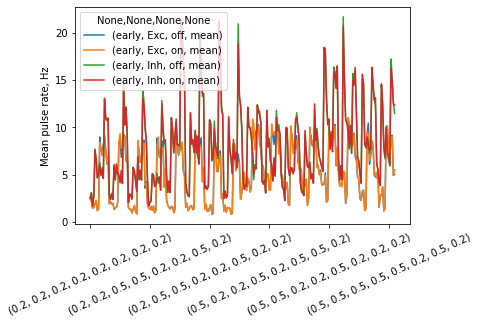

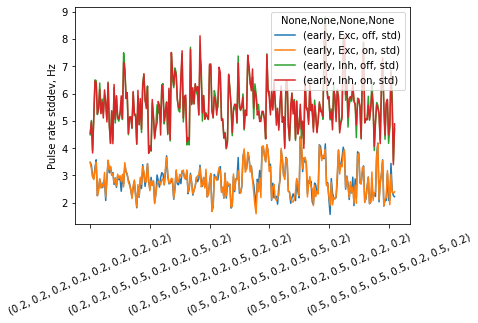

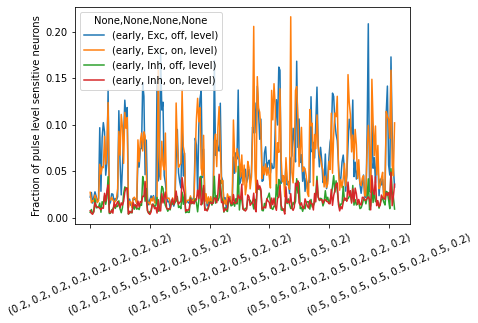

In [35]:
sdataL.loc[ix['early',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean pulse rate, Hz')
sdataL.loc[ix['early',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Pulse rate stddev, Hz')
sdataL.loc[ix['early',:,:,['level']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Fraction of pulse level sensitive neurons');

In [ ]:
def nostim(model, dt, early = (10,20), late = (50,60)):
    def get_empty(secs):
        return cantu.get_inputs(int(np.round(secs/dt)), (0,), (0,),
                               device = device, batch_size = batch_size)

    # Settle without observation until early begins:
    if early[0] > 0:
        model(get_empty(early[0]))

    # Observe spikes in early window:
    return model(get_empty(early[1] - early[0]))

m = cantata.Conductor(conf, batch_size, dt, shared_weights = False).to(device)
with torch.no_grad():
    Xs = nostim(m, dt, early, late) # t,b,N

In [ ]:
X = torch.cat(Xs, dim=2)
X1 = X[:,:1]
R1 = cp.get_rates(X1,m,batch_size,dt)
cp.raster(X1, m, rates=R1)

In [ ]:
R = cp.get_rates(X,m,batch_size,dt) # t,b,npop
R_sd, R_mean = torch.std_mean(R, dim=0)
Rn = R-R_mean
autocorr = torch.nn.functional.conv1d(
    input = R.permute(1,2,0).reshape(1, -1, R.shape[0]), # 1, b*npop, t
    weight = R.permute(1,2,0).reshape(-1, 1, R.shape[0]), # b*npop, 1, t
    groups = R.shape[1] * R.shape[2],
    padding = 500
).reshape(R.shape[1], R.shape[2], -1) # b, npop, 2*padding+1
autocorr /= autocorr[:,:,500][:,:,None]

In [ ]:
plt.plot(autocorr[0].cpu().numpy().T[480:520])

In [ ]:
plt.figure(figsize=figsize)
plt.plot(R[270:300,0,1].cpu())